# Genomic Grammar Analysis

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import *
from keras.models import Model
from keras import backend as K

/home/jenhan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
import numpy as np
import Bio
from Bio import SeqIO
import seaborn as sns
import pandas as pd
import Bio.motifs
%matplotlib inline
from sklearn import model_selection
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
sns.set_context('notebook')

In [3]:
if not os.path.isdir('/home/jtao/analysis/genomic_grammar_analysis/'):
    os.mkdir('/home/jtao/analysis/genomic_grammar_analysis')
os.chdir('/home/jtao/analysis/genomic_grammar_analysis')

## Functions

In [4]:
def convert_sequences_to_array(sequences):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]
             
    '''

    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0.25,0.25,0.25,0.25]}

    sequence_array_list = []
    for seq in sequences:
        seq_array = []
        for nuc in seq:
            seq_array.append(nucleotide_array_dict[nuc])
        seq_array = np.array(seq_array)
        sequence_array_list.append(seq_array)
    sequence_array_list = np.array(sequence_array_list)
    return sequence_array_list

## Extract Sequence

In [612]:
%%bash
if [ ! -d ./bed_files ]; then mkdir ./bed_files; else rm ./bed_files/*; fi
for peak in ./atac_idr_peaks/*tsv;
do echo $peak;
new_path=${peak/atac_idr_peaks/bed_files};
new_path=${new_path/.tsv/.bed};
echo $new_path;
pos2bed.pl $peak >$new_path
done

./atac_idr_peaks/c57bl6_il4-24h_peaks.tsv
./bed_files/c57bl6_il4-24h_peaks.bed
./atac_idr_peaks/c57bl6_kla-1h_peaks.tsv
./bed_files/c57bl6_kla-1h_peaks.bed
./atac_idr_peaks/c57bl6_veh_peaks.tsv
./bed_files/c57bl6_veh_peaks.bed


bash: line 7: pos2bed.pl: command not found
bash: line 7: pos2bed.pl: command not found
bash: line 7: pos2bed.pl: command not found


In [78]:
%%bash
if [ ! -d ./fasta_files ]; then mkdir ./fasta_files; else rm ./fasta_files/*; fi
for bed_path in ./bed_files/*bed;
do echo $bed_path;
new_path=${bed_path/bed_files/fasta_files};
new_path=${new_path/.bed/.fa};
echo $new_path;
/home/jtao/code/tba/model_training/extract_sequences.py $bed_path mm10 $new_path
done

./bed_files/c57bl6_il4-24h_peaks.bed
./fasta_files/c57bl6_il4-24h_peaks.fa
reading genome mm10
./bed_files/c57bl6_kla-1h_peaks.bed
./fasta_files/c57bl6_kla-1h_peaks.fa
reading genome mm10
./bed_files/c57bl6_veh_peaks.bed
./fasta_files/c57bl6_veh_peaks.fa
reading genome mm10


rm: cannot remove ‘./fasta_files/*’: No such file or directory


## Generate Background Coordinates

In [81]:
%%bash
if [ ! -d ./background_files ]; then mkdir ./background_files; else rm ./background_files/*; fi
for bed_path in ./bed_files/*bed;
do echo $bed_path;
echo /home/jtao/code/tba/model_training/generate_background_coordinates.py $bed_path ./background_files -genome mm10
done

./bed_files/c57bl6_il4-24h_peaks.bed
/home/jtao/code/tba/model_training/generate_background_coordinates.py ./bed_files/c57bl6_il4-24h_peaks.bed ./background_files -genome mm10
./bed_files/c57bl6_kla-1h_peaks.bed
/home/jtao/code/tba/model_training/generate_background_coordinates.py ./bed_files/c57bl6_kla-1h_peaks.bed ./background_files -genome mm10
./bed_files/c57bl6_veh_peaks.bed
/home/jtao/code/tba/model_training/generate_background_coordinates.py ./bed_files/c57bl6_veh_peaks.bed ./background_files -genome mm10


rm: cannot remove ‘./background_files/*’: No such file or directory


In [88]:
%%bash
rm ./make_background.sh
script_path="./make_background.sh"
if [ ! -d ./background_files/ ]; then mkdir ./background_files/ ; fi
for i in ./bed_files/*bed;
do 
    factor=${i##*/};
    factor=${factor%.bed};
    fasta_path="./background_files/${factor}_background.fasta"
    bed_path="./background_files/${factor}_background.bed"

    echo "/home/jtao/code/tba/model_training/generate_background_coordinates.py $i ./background_files/ -genome mm10" >> $script_path;
    echo "mv ./background_files/background.bed $bed_path" >> $script_path;
    echo "mv ./background_files/background.fasta $fasta_path" >> $script_path;
done

In [ ]:
%%bash
rm ./background/*
chmod a+x ./*sh
bash ./make_background.sh

## Read in Data

In [186]:
# positive_seqRecords = list(SeqIO.parse('./fasta_files/c57bl6_il4-24h_peaks.fa', 'fasta'))
# negative_seqRecords = list(SeqIO.parse('./background_files/c57bl6_il4-24h_peaks_background.fasta', 'fasta'))

positive_seqRecords = list(SeqIO.parse('/home/jtao/analysis/ap1_fdr_analysis/fasta_files/c57bl6_atf3_veh_idr.fasta', 'fasta'))
negative_seqRecords = list(SeqIO.parse('./background_files/c57bl6_il4-24h_peaks_background.fasta', 'fasta'))[:len(positive_seqRecords)]

fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
    [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

sequence_arrays = convert_sequences_to_array(fasta_seq)
sequence_arrays = np.array(sequence_arrays)

sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)
sequence_rc_arrays = np.array(sequence_rc_arrays)


labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
labels = np.array(labels)

x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Count Params

In [7]:
def count_num_params(seq_size,
                     num_motifs, 
                     motif_size,
                     adjacent_bp_pool_size,
                     attention_dim,
                     attention_hops,
                     num_dense_neurons
                    ):
    total_params = 0
    
    # convolution layer
    convolution_params = num_motifs * motif_size * 4
    total_params += convolution_params
    print('Convolution Params:', convolution_params)
    
    # lstm layer
    # account for pooling
    lstm_input_size = num_motifs
    # account for reverse complement sequence
    lstm_input_size = lstm_input_size * 2
    
    num_lstm_neurons = seq_size/ adjacent_bp_pool_size
    
    lstm_params = lstm_input_size * 4 * num_lstm_neurons
    # account for bidrectional lstm
    lstm_params = lstm_params * 2
    
    total_params += lstm_params
    print('LSTM Params:', lstm_params)
    
    # attention layer
    # first layer of perceptron
    attention_params = attention_dim * (seq_size/adjacent_bp_pool_size) 
    # account for hops of attention (second layer of perceptron)
    attention_params += attention_dim * attention_hops
    
    total_params += attention_params
    print('Attention Params:', attention_params)
    
    # dense layer
    dense_params = (seq_size/adjacent_bp_pool_size) * num_dense_neurons
    total_params += dense_params
    print('Dense Params:', dense_params)
    
    return total_params

In [8]:
seq_size = 150
num_classes = 2
num_motifs = 50
motif_size = 20
adjacent_bp_pool_size = 10
attention_dim = 50 # 350 from A Structured Self-attentive Sentence Embedding
attention_hops = 1 # from A Structured Self-attentive Sentence Embedding
num_dense_neurons = 500 # 2-layer, 2000 units, from A Structured Self-attentive Sentence Embedding

count_num_params(seq_size,
    num_motifs, 
    motif_size,
    adjacent_bp_pool_size,
    attention_dim,
    attention_hops,
    num_dense_neurons
    )

Convolution Params: 4000
LSTM Params: 12000.0
Attention Params: 800.0
Dense Params: 7500.0


24300.0

## Define Model

In [141]:
seq_size = 150
num_classes = 2
num_motifs = 100
motif_size = 20
adjacent_bp_pool_size = 1
attention_dim = 50 
attention_hops = 1 
num_dense_neurons = 500 

### Top Motif Scores

In [142]:
total_seq_length = len(fasta_seq[0])

input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
input_rev = Input(shape=(total_seq_length,4), name='input_rev')

# find motifs
convolution_layer = Conv1D(filters=num_motifs, 
    kernel_size=motif_size,
    activation='relu',
    input_shape=(total_seq_length,4),
    name='convolution_layer',
    padding = 'same'
    )
forward_motif_scores = convolution_layer(input_fwd)
reverse_motif_scores = convolution_layer(input_rev)
print('forward_motif_scores', forward_motif_scores.shape)

# crop motif scores to avoid parts of sequence where motif score is computed in only one direction
to_crop = int((total_seq_length - seq_size)/2)
crop_layer = Cropping1D(cropping=(to_crop, to_crop), 
    name='crop_layer')
cropped_fwd_scores = crop_layer(forward_motif_scores)
cropped_rev_scores = crop_layer(reverse_motif_scores)
print('cropped_fwd_scores', cropped_fwd_scores.shape)

# # flip motif scores
# flip_layer = Lambda(lambda x: K.reverse(x,axes=0),
#     output_shape=(seq_size, num_motifs),
#     name='flip_layer')
# flipped_rev_scores = flip_layer(cropped_rev_scores)
# print('flipped_rev_scores', flipped_rev_scores.shape)

# calculate max scores for each orientation
seq_pool_layer = MaxPool1D(pool_size=seq_size)
max_fwd_scores = seq_pool_layer(cropped_fwd_scores)
max_rev_scores = seq_pool_layer(cropped_rev_scores)
print('max_fwd_scores', max_fwd_scores.shape)

# calculate max score for strand
orientation_max_layer = Maximum()
max_seq_scores = orientation_max_layer([max_fwd_scores, max_rev_scores])
print('max_seq_scores', max_seq_scores.shape)

# fully connected layer
dense_out = Dense(num_dense_neurons, activation='relu', 
                 )(max_seq_scores)

# drop out
drop_out = Dropout(0.25)(dense_out)

# make prediction
flattened = Flatten()(drop_out)
predictions = Dense(num_classes,
                    activation = 'softmax', 
                   )(flattened)


forward_motif_scores (?, 200, 100)
cropped_fwd_scores (?, 150, 100)
max_fwd_scores (?, 1, 100)
max_seq_scores (?, 1, 100)


In [143]:
# define and compile model
convolution_model = Model(inputs=[input_fwd, input_rev], outputs=predictions)

convolution_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

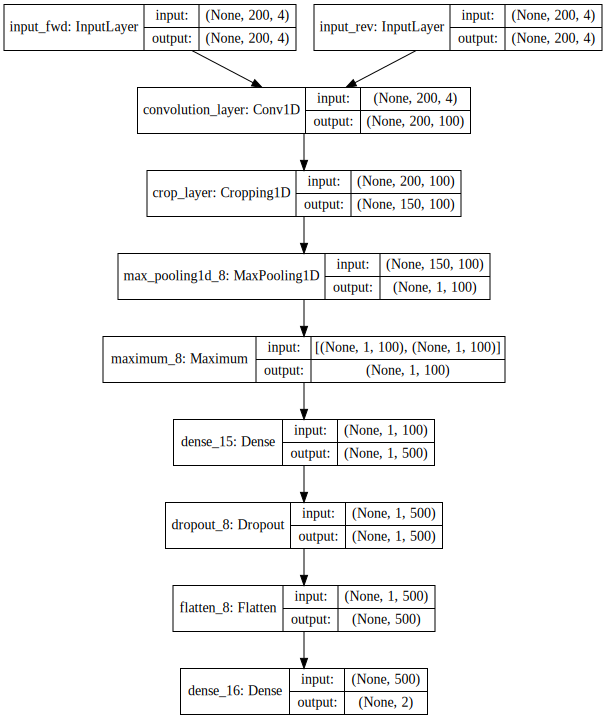

In [144]:
SVG(model_to_dot(convolution_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [145]:
convolution_model.fit([x_train, x_rc_train], y_train,
          batch_size=100,
          epochs=10,
          verbose=1,
          validation_data=([x_test, x_rc_test], y_test))
score = convolution_model.evaluate([x_test, x_rc_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 59352 samples, validate on 14838 samples
Epoch 1/10
59352/59352 [==============================] - 5s 80us/step - loss: 0.5249 - acc: 0.7198 - val_loss: 0.4040 - val_acc: 0.8152
Epoch 2/10
59352/59352 [==============================] - 4s 60us/step - loss: 0.3783 - acc: 0.8312 - val_loss: 0.3662 - val_acc: 0.8353
Epoch 3/10
59352/59352 [==============================] - 4s 60us/step - loss: 0.3459 - acc: 0.8490 - val_loss: 0.3574 - val_acc: 0.8425
Epoch 4/10
59352/59352 [==============================] - 4s 60us/step - loss: 0.3189 - acc: 0.8631 - val_loss: 0.3472 - val_acc: 0.8457
Epoch 5/10
59352/59352 [==============================] - 4s 60us/step - loss: 0.3075 - acc: 0.8688 - val_loss: 0.3667 - val_acc: 0.8375
Epoch 6/10
59352/59352 [==============================] - 4s 60us/step - loss: 0.2954 - acc: 0.8748 - val_loss: 0.3948 - val_acc: 0.8215
Epoch 7/10
59352/59352 [==============================] - 4s 60us/step - loss: 0.2853 - acc: 0.8799 - val_loss: 0.3662 - val_acc

In [146]:
probs = convolution_model.predict([x_test, x_rc_test])

sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )

0.9290040404301393

### Attention Model

In [214]:
seq_size = 150
num_classes = 2
num_motifs = 50
motif_size = 20
adjacent_bp_pool_size = 10
attention_dim = 350 
attention_hops = 1 
num_dense_neurons = 1000 
count_num_params(seq_size,
    num_motifs, 
    motif_size,
    adjacent_bp_pool_size,
    attention_dim,
    attention_hops,
    num_dense_neurons
    )

Convolution Params: 4000
LSTM Params: 12000.0
Attention Params: 5600.0
Dense Params: 15000.0


36600.0

In [162]:
total_seq_length = len(fasta_seq[0])

input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
input_rev = Input(shape=(total_seq_length,4), name='input_rev')

# find motifs
convolution_layer = Conv1D(filters=num_motifs, 
    kernel_size=motif_size,
    activation='relu',
    input_shape=(total_seq_length,4),
    name='convolution_layer',
    padding = 'same'
    )
forward_motif_scores = convolution_layer(input_fwd)
reverse_motif_scores = convolution_layer(input_rev)
print('forward_motif_scores', forward_motif_scores.shape)

# crop motif scores to avoid parts of sequence where motif score is computed in only one direction
to_crop = int((total_seq_length - seq_size)/2)
crop_layer = Cropping1D(cropping=(to_crop, to_crop), 
    name='crop_layer')
cropped_fwd_scores = crop_layer(forward_motif_scores)
cropped_rev_scores = crop_layer(reverse_motif_scores)
print('cropped_fwd_scores', cropped_fwd_scores.shape)

# flip motif scores
flip_layer = Lambda(lambda x: K.reverse(x,axes=0),
    output_shape=(seq_size, num_motifs),
    name='flip_layer')
flipped_rev_scores = flip_layer(cropped_rev_scores)
print('flipped_rev_scores', flipped_rev_scores.shape)

# concatenate motif scores
concatenate_layer = keras.layers.Concatenate(axis=2, name='concatenate_layer')
concatenated_motif_scores = concatenate_layer([cropped_fwd_scores, flipped_rev_scores])
print('concatenated_motif_scores', concatenated_motif_scores.shape)

# pool across length of sequence
sequence_pooling_layer = MaxPool1D(pool_size=adjacent_bp_pool_size, 
    strides=adjacent_bp_pool_size,
    name='sequence_pooling_layer')
pooled_scores = sequence_pooling_layer(concatenated_motif_scores)
print('pooled_scores', pooled_scores.shape)

# bidirectional LSTM
forward_lstm_layer = LSTM(units=int(seq_size/adjacent_bp_pool_size),
    return_sequences=True,
    name = 'forward_lstm_layer'
    )
forward_hidden_states = forward_lstm_layer(pooled_scores)
print('forward_hidden_states', forward_hidden_states.shape)

reverse_lstm_layer = LSTM(units=int(seq_size/adjacent_bp_pool_size),
    return_sequences=True,
    name = 'reverse_lstm_layer',
    go_backwards=True
    )
reverse_hidden_states = reverse_lstm_layer(pooled_scores)
print('reverse_hidden_states', reverse_hidden_states.shape)

# concatenate lstm hidden states
lstm_concatenate_layer = Concatenate(axis=2)
bilstm_hidden_states = lstm_concatenate_layer([forward_hidden_states, reverse_hidden_states])
print('bilstm_hidden_states', bilstm_hidden_states.shape)

# fully connected layer
dense_layer = Dense(num_dense_neurons, 
    activation='relu', 
    name = 'dense_layer'
    )

dense_output = dense_layer(bilstm_hidden_states)

# drop out
drop_out = Dropout(0.25,name='dense_dropout')(dense_output)

# make prediction
flattened = Flatten(name='flatten')(drop_out)
predictions = Dense(num_classes,
                    name='predictions',
                    activation = 'softmax', 
                   )(flattened)

forward_motif_scores (?, 200, 100)
cropped_fwd_scores (?, 150, 100)
flipped_rev_scores (?, 150, 100)
concatenated_motif_scores (?, 150, 200)
pooled_scores (?, 15, 200)
forward_hidden_states (?, ?, 15)
reverse_hidden_states (?, ?, 15)
bilstm_hidden_states (?, ?, 30)


In [163]:
# define and compile model
bilstm_model = Model(inputs=[input_fwd, input_rev], outputs=predictions)

bilstm_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

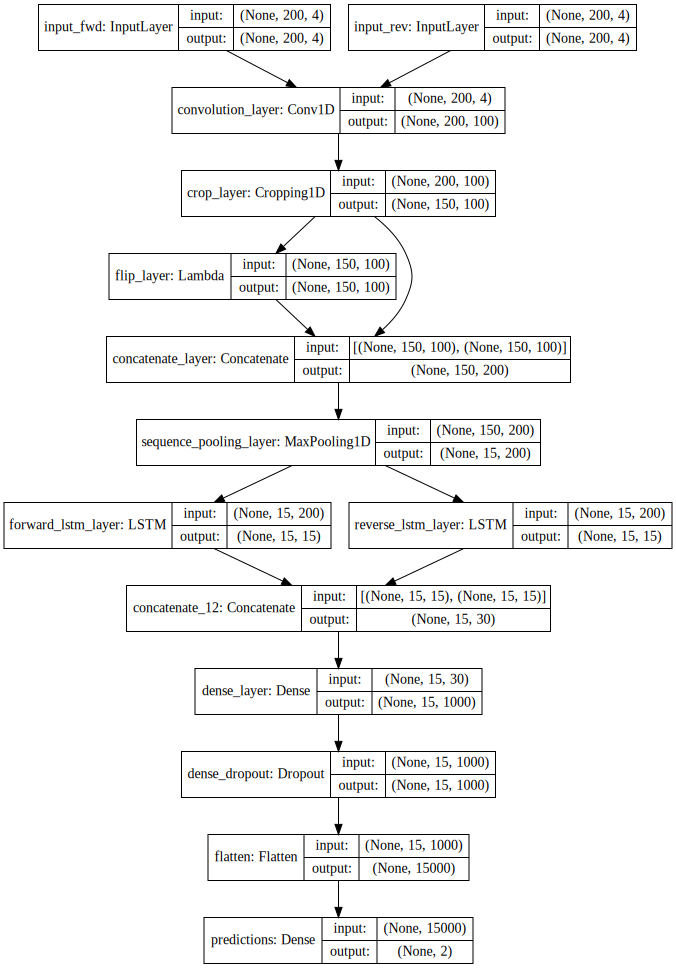

In [184]:
SVG(model_to_dot(bilstm_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [165]:
bilstm_model.fit([x_train, x_rc_train], y_train,
          batch_size=100,
          epochs=10,
          verbose=1,
          validation_data=([x_test, x_rc_test], y_test))
score = bilstm_model.evaluate([x_test, x_rc_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 59352 samples, validate on 14838 samples
Epoch 1/10
59352/59352 [==============================] - 20s 338us/step - loss: 0.6107 - acc: 0.6445 - val_loss: 0.5357 - val_acc: 0.7328
Epoch 2/10
59352/59352 [==============================] - 18s 310us/step - loss: 0.4618 - acc: 0.7808 - val_loss: 0.4214 - val_acc: 0.8024
Epoch 3/10
59352/59352 [==============================] - 18s 310us/step - loss: 0.3931 - acc: 0.8217 - val_loss: 0.3870 - val_acc: 0.8267
Epoch 4/10
59352/59352 [==============================] - 18s 310us/step - loss: 0.3601 - acc: 0.8420 - val_loss: 0.3789 - val_acc: 0.8333
Epoch 5/10
59352/59352 [==============================] - 18s 310us/step - loss: 0.3352 - acc: 0.8551 - val_loss: 0.3592 - val_acc: 0.8430
Epoch 6/10
59352/59352 [==============================] - 18s 310us/step - loss: 0.3200 - acc: 0.8625 - val_loss: 0.3528 - val_acc: 0.8469
Epoch 7/10
59352/59352 [==============================] - 18s 310us/step - loss: 0.3077 - acc: 0.8692 - val_loss: 0.

In [166]:
probs = bilstm_model.predict([x_test, x_rc_test])

sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )

0.926895845746917

### Attention Model

In [627]:
seq_size = 150
num_classes = 2
num_motifs = 25
motif_size = 12
adjacent_bp_pool_size = 1
attention_dim = 200
attention_hops = 1
num_dense_neurons = 500 
count_num_params(seq_size,
    num_motifs, 
    motif_size,
    adjacent_bp_pool_size,
    attention_dim,
    attention_hops,
    num_dense_neurons
    )

Convolution Params: 1200
LSTM Params: 60000.0
Attention Params: 30200.0
Dense Params: 75000.0


166400.0

In [631]:
total_seq_length = len(fasta_seq[0])

input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
input_rev = Input(shape=(total_seq_length,4), name='input_rev')

### find motifs ###
convolution_layer = Conv1D(filters=num_motifs, 
    kernel_size=motif_size,
    activation='relu',
    input_shape=(total_seq_length,4),
    name='convolution_layer',
    padding = 'same'
    )
forward_motif_scores = convolution_layer(input_fwd)
reverse_motif_scores = convolution_layer(input_rev)
print('forward_motif_scores', forward_motif_scores.get_shape())

### crop motif scores to avoid parts of sequence where motif score is computed in only one direction ###
to_crop = int((total_seq_length - seq_size)/2)
crop_layer = Cropping1D(cropping=(to_crop, to_crop), 
    name='crop_layer')
cropped_fwd_scores = crop_layer(forward_motif_scores)
cropped_rev_scores = crop_layer(reverse_motif_scores)
print('cropped_fwd_scores', cropped_fwd_scores.get_shape())

### flip motif scores ###
flip_layer = Lambda(lambda x: K.reverse(x,axes=0),
    output_shape=(seq_size, num_motifs),
    name='flip_layer')
flipped_rev_scores = flip_layer(cropped_rev_scores)
print('flipped_rev_scores', flipped_rev_scores.get_shape())

### concatenate motif scores ###
concatenate_layer = keras.layers.Concatenate(axis=2, name='concatenate_layer')
concatenated_motif_scores = concatenate_layer([cropped_fwd_scores, flipped_rev_scores])
print('concatenated_motif_scores', concatenated_motif_scores.get_shape())

### pool across length of sequence ###
sequence_pooling_layer = MaxPool1D(pool_size=adjacent_bp_pool_size, 
    strides=adjacent_bp_pool_size,
    name='sequence_pooling_layer')
pooled_scores = sequence_pooling_layer(concatenated_motif_scores)
print('pooled_scores', pooled_scores.get_shape())

## bidirectional LSTM ###
forward_lstm_layer = LSTM(units=int(seq_size/adjacent_bp_pool_size),
    return_sequences=True,
    input_shape = (int(seq_size/adjacent_bp_pool_size), 2*num_motifs),
    name = 'forward_lstm_layer'
    )
forward_hidden_states = forward_lstm_layer(pooled_scores)
print('forward_hidden_states', forward_hidden_states.get_shape())

reverse_lstm_layer = LSTM(units=int(seq_size/adjacent_bp_pool_size),
    return_sequences=True,
    input_shape = (int(seq_size/adjacent_bp_pool_size), 2*num_motifs),
    name = 'reverse_lstm_layer',
    go_backwards=True,
    )
reverse_hidden_states = reverse_lstm_layer(pooled_scores)
print('reverse_hidden_states', reverse_hidden_states.get_shape())
### concatenate lstm hidden states ###
lstm_concatenate_layer = Concatenate(axis=2)
bilstm_hidden_states = lstm_concatenate_layer([forward_hidden_states, reverse_hidden_states])

# bilstm_layer = Bidirectional(LSTM(
#     units=int(seq_size/adjacent_bp_pool_size),
#     return_sequences=True,
#     input_shape = (int(seq_size/adjacent_bp_pool_size), 2*num_motifs),
#     name = 'bilstm_layer'))
# bilstm_hidden_states = bilstm_layer(pooled_scores)
print('bilstm_hidden_states', bilstm_hidden_states.get_shape())

### attention layer ###
# transpose hidden states
# transpose_layer = Lambda(lambda x: K.permute_dimensions(x,(0,2,1)),
#     name='transpose_layer')
# transposed_hidden_states = transpose_layer(bilstm_hidden_states)
# print('transposed_hidden_states', transposed_hidden_states.get_shape())

# tanh layer
attention_tanh_layer = Dense(attention_dim,
    activation='tanh',
    use_bias=False,
    name = 'attention_tanh_layer')
attention_tanh_layer_out = attention_tanh_layer(bilstm_hidden_states)
print('attention_tanh_layer_out', attention_tanh_layer_out.get_shape())

# rotate_layer = Lambda(lambda x: K.permute_dimensions(x,(0,2,1)),
# #     name='rotate_layer'
#     )
# rotated_attention_tanh_layer_out = rotate_layer(attention_tanh_layer_out)

# outer layer
attention_outer_layer = Dense(attention_hops,
    activation='relu',
    use_bias=False,
    name = 'attention_outer_layer')
attention_outer_layer_out = attention_outer_layer(attention_tanh_layer_out)
print('attention_outer_layer_out', attention_outer_layer_out.get_shape())

# apply softmax
softmax_layer = Softmax(axis=1, name='attention_softmax_layer')
attention_softmax_layer_out = softmax_layer(attention_outer_layer_out)
print('attention_softmax_layer_out', attention_softmax_layer_out.get_shape())

# attend to hidden states
attending_layer = Dot(axes=(1,1),
    name='attending_layer')

attended_states = attending_layer([attention_softmax_layer_out, bilstm_hidden_states])
print('attended_states', attended_states.get_shape())

# # fully connected layer
dense_layer = Dense(num_dense_neurons, 
    activation='relu', 
    name = 'dense_layer'
    )

dense_output = dense_layer(attended_states)

# drop out
drop_out = Dropout(0.25,name='dense_dropout')(dense_output)

# make prediction
flattened = Flatten(name='flatten')(drop_out)
predictions = Dense(num_classes,
                    name='predictions',
                    activation = 'softmax', 
                   )(flattened)



forward_motif_scores (?, 200, 25)
cropped_fwd_scores (?, 150, 25)
flipped_rev_scores (?, 150, 25)
concatenated_motif_scores (?, 150, 50)
pooled_scores (?, 150, 50)
forward_hidden_states (?, ?, 150)
reverse_hidden_states (?, ?, 150)
bilstm_hidden_states (?, ?, 300)
attention_tanh_layer_out (?, 150, 200)
attention_outer_layer_out (?, 150, 1)
attention_softmax_layer_out (?, 150, 1)
attended_states (?, 1, 300)


In [632]:
# define and compile model
attention_model = Model(inputs=[input_fwd, input_rev], outputs=predictions)

attention_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

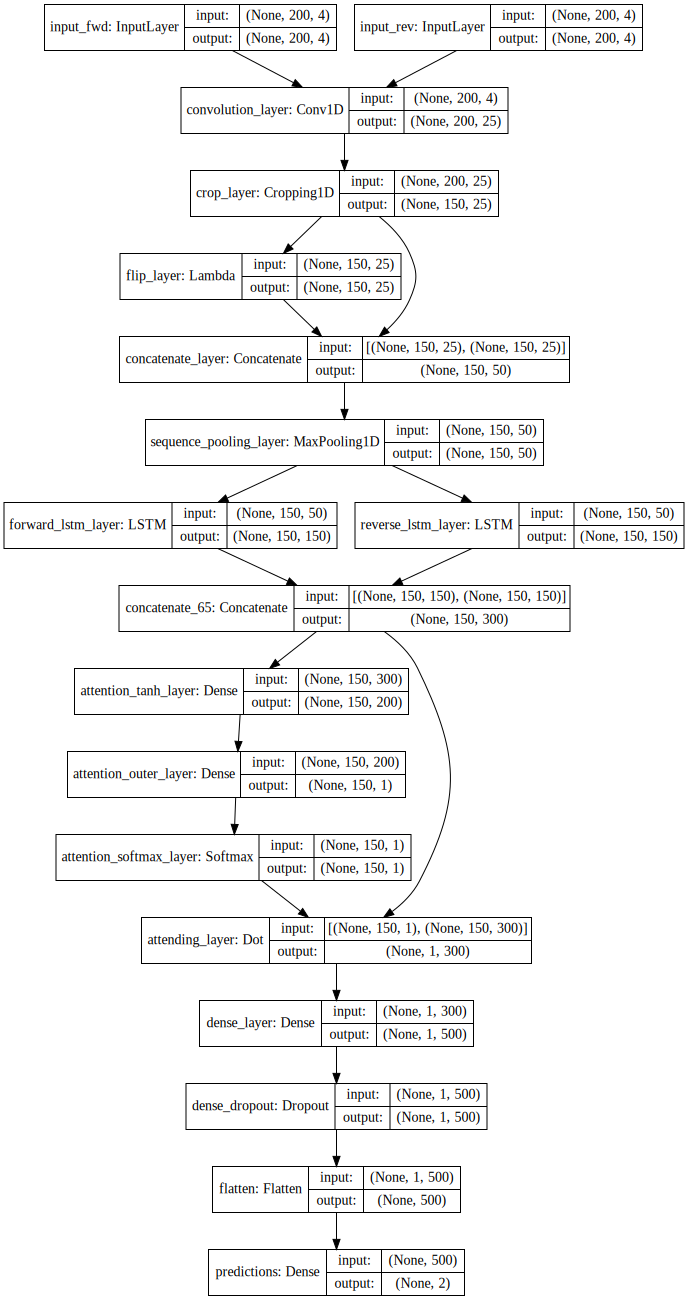

In [633]:
keras.utils.plot_model(attention_model, to_file='attention_model.pdf')
SVG(model_to_dot(attention_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))


In [250]:
parallel_attention_model = keras.utils.multi_gpu_model(attention_model, gpus=2)
parallel_attention_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
parallel_attention_model.fit([x_train, x_rc_train], y_train,
          batch_size=200,
          epochs=50,
          verbose=1,
          validation_data=([x_test, x_rc_test], y_test))
score = parallel_attention_model.evaluate([x_test, x_rc_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [261]:
probs = attention_model.predict([x_test, x_rc_test])

sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )

0.9507857947721864

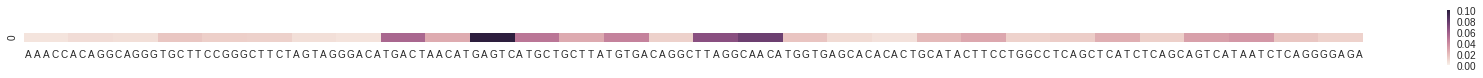

In [270]:
attention_output, full_attention, attended_sequence = get_sequence_attention(attention_model,
                      str(positive_seqRecords[2].seq),
                      5)
frame = pd.DataFrame(full_attention).T
frame.columns = list(attended_sequence)
fig, ax = plt.subplots(figsize=(30,1)) 
hm=sns.heatmap(frame, square=True, ax=ax, vmin=0, vmax=0.10)

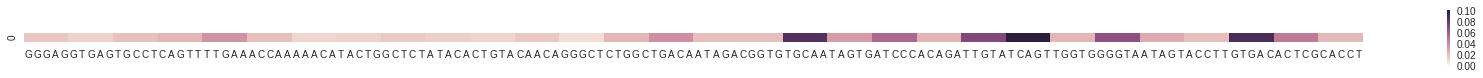

In [277]:
attention_output, full_attention, attended_sequence = get_sequence_attention(attention_model,
                      str(positive_seqRecords[9000].seq),
                      5)
frame = pd.DataFrame(full_attention).T
frame.columns = list(attended_sequence)
fig, ax = plt.subplots(figsize=(30,1)) 
hm=sns.heatmap(frame, square=True, ax=ax, vmin=0, vmax=0.10)

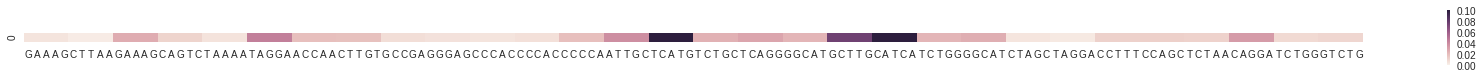

In [280]:
attention_output, full_attention, attended_sequence = get_sequence_attention(attention_model,
                      str(positive_seqRecords[999].seq),
                      5)
frame = pd.DataFrame(full_attention).T
frame.columns = list(attended_sequence)
fig, ax = plt.subplots(figsize=(30,1)) 
hm=sns.heatmap(frame, square=True, ax=ax, vmin=0, vmax=0.10)

In [279]:
def get_sequence_attention(model, sequence, adjacent_bp_pool_size):
    get_attention = K.function([model.get_layer('input_fwd').input, 
                                model.get_layer('input_rev').input,
                                K.learning_phase()
                               ], 
                               [model.get_layer('attention_softmax_layer').output])
    fwd_seq = sequence[:200]
    rev_seq = str(Bio.Seq.Seq(fwd_seq).reverse_complement())
    
    fwd_seq_array = convert_sequences_to_array([fwd_seq])[0]
    rev_seq_array = convert_sequences_to_array([rev_seq])[0]

    layer_output = get_attention(([fwd_seq_array], [rev_seq_array], 0))[0]
    reshaped_output = layer_output.reshape((layer_output.shape[1], layer_output.shape[2]))


    full_attention = []
    for x in reshaped_output:
        for i in range(adjacent_bp_pool_size):
            full_attention.append(x)
    full_attention = np.array(full_attention)

    crop_distance = int((len(fwd_seq) - full_attention.shape[0])/2)

    attended_sequence = fwd_seq[crop_distance:-crop_distance]
    return layer_output, full_attention, attended_sequence

In [403]:
def convert_arrays_to_sequences(sequence_arrays):
    sequence_list = []
    for arr in sequence_arrays:
        current_seq = ''
        for pos in arr:
            if int(pos[0]) == 1:
                current_seq += 'A'
            elif int(pos[1]) == 1:
                current_seq += 'C'
            elif int(pos[2]) == 1:
                current_seq += 'G'
            elif int(pos[3]) == 1:
                current_seq += 'T'
            else:
                current_seq += 'N'
        sequence_list.append(current_seq)
    return sequence_list

## Train Models For each signal

In [289]:
def get_attention_model(total_seq_length,
                        seq_size,
                        num_motifs, 
                        motif_size,
                        adjacent_bp_pool_size,
                        attention_dim,
                        attention_hops,
                        num_dense_neurons):
    input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
    input_rev = Input(shape=(total_seq_length,4), name='input_rev')

    ### find motifs ###
    convolution_layer = Conv1D(filters=num_motifs, 
        kernel_size=motif_size,
        activation='relu',
        input_shape=(total_seq_length,4),
        name='convolution_layer',
        padding = 'same'
        )
    forward_motif_scores = convolution_layer(input_fwd)
    reverse_motif_scores = convolution_layer(input_rev)
    print('forward_motif_scores', forward_motif_scores.get_shape())

    ### crop motif scores to avoid parts of sequence where motif score is computed in only one direction ###
    to_crop = int((total_seq_length - seq_size)/2)
    crop_layer = Cropping1D(cropping=(to_crop, to_crop), 
        name='crop_layer')
    cropped_fwd_scores = crop_layer(forward_motif_scores)
    cropped_rev_scores = crop_layer(reverse_motif_scores)
    print('cropped_fwd_scores', cropped_fwd_scores.get_shape())

    ### flip motif scores ###
    flip_layer = Lambda(lambda x: K.reverse(x,axes=0),
        output_shape=(seq_size, num_motifs),
        name='flip_layer')
    flipped_rev_scores = flip_layer(cropped_rev_scores)
    print('flipped_rev_scores', flipped_rev_scores.get_shape())

    ### concatenate motif scores ###
    concatenate_layer = keras.layers.Concatenate(axis=2, name='concatenate_layer')
    concatenated_motif_scores = concatenate_layer([cropped_fwd_scores, flipped_rev_scores])
    print('concatenated_motif_scores', concatenated_motif_scores.get_shape())

    ### pool across length of sequence ###
    sequence_pooling_layer = MaxPool1D(pool_size=adjacent_bp_pool_size, 
        strides=adjacent_bp_pool_size,
        name='sequence_pooling_layer')
    pooled_scores = sequence_pooling_layer(concatenated_motif_scores)
    print('pooled_scores', pooled_scores.get_shape())

    ## bidirectional LSTM ###
    forward_lstm_layer = LSTM(units=int(seq_size/adjacent_bp_pool_size),
        return_sequences=True,
        input_shape = (int(seq_size/adjacent_bp_pool_size), 2*num_motifs),
        name = 'forward_lstm_layer'
        )
    forward_hidden_states = forward_lstm_layer(pooled_scores)
    print('forward_hidden_states', forward_hidden_states.get_shape())

    reverse_lstm_layer = LSTM(units=int(seq_size/adjacent_bp_pool_size),
        return_sequences=True,
        input_shape = (int(seq_size/adjacent_bp_pool_size), 2*num_motifs),
        name = 'reverse_lstm_layer',
        go_backwards=True,
        )
    reverse_hidden_states = reverse_lstm_layer(pooled_scores)
    print('reverse_hidden_states', reverse_hidden_states.get_shape())
    ### concatenate lstm hidden states ###
    lstm_concatenate_layer = Concatenate(axis=2)
    bilstm_hidden_states = lstm_concatenate_layer([forward_hidden_states, reverse_hidden_states])

    print('bilstm_hidden_states', bilstm_hidden_states.get_shape())

    # tanh layer
    attention_tanh_layer = Dense(attention_dim,
        activation='tanh',
        use_bias=False,
        name = 'attention_tanh_layer')
    attention_tanh_layer_out = attention_tanh_layer(bilstm_hidden_states)
    print('attention_tanh_layer_out', attention_tanh_layer_out.get_shape())

    # outer layer
    attention_outer_layer = Dense(attention_hops,
        activation='relu',
        use_bias=False,
        name = 'attention_outer_layer')
    attention_outer_layer_out = attention_outer_layer(attention_tanh_layer_out)
    print('attention_outer_layer_out', attention_outer_layer_out.get_shape())

    # apply softmax
    softmax_layer = Softmax(axis=1, name='attention_softmax_layer')
    attention_softmax_layer_out = softmax_layer(attention_outer_layer_out)
    print('attention_softmax_layer_out', attention_softmax_layer_out.get_shape())

    # attend to hidden states
    attending_layer = Dot(axes=(1,1),
        name='attending_layer')

    attended_states = attending_layer([attention_softmax_layer_out, bilstm_hidden_states])
    print('attended_states', attended_states.get_shape())

    # # fully connected layer
    dense_layer = Dense(num_dense_neurons, 
        activation='relu', 
        name = 'dense_layer'
        )

    dense_output = dense_layer(attended_states)

    # drop out
    drop_out = Dropout(0.25,name='dense_dropout')(dense_output)

    # make prediction
    flattened = Flatten(name='flatten')(drop_out)
    predictions = Dense(num_classes,
                        name='predictions',
                        activation = 'softmax', 
                       )(flattened)
    # define and compile model
    model = Model(inputs=[input_fwd, input_rev], outputs=predictions)

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

In [585]:
total_seq_length = len(fasta_seq[0])
seq_size = 150
num_classes = 2
num_motifs = 50
motif_size = 15
adjacent_bp_pool_size = 5
attention_dim = 200
attention_hops = 1
num_dense_neurons = 500 
count_num_params(seq_size,
    num_motifs, 
    motif_size,
    adjacent_bp_pool_size,
    attention_dim,
    attention_hops,
    num_dense_neurons
    )

Convolution Params: 3000
LSTM Params: 24000.0
Attention Params: 6200.0
Dense Params: 15000.0


48200.0

### KLA

In [606]:
positive_seqRecords = list(SeqIO.parse('./fasta_files/c57bl6_kla-1h_peaks.fa', 'fasta'))
negative_seqRecords = list(SeqIO.parse('./background_files/c57bl6_kla-1h_peaks_background.fasta', 'fasta'))

fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
    [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

sequence_arrays = convert_sequences_to_array(fasta_seq)
sequence_arrays = np.array(sequence_arrays)

sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)
sequence_rc_arrays = np.array(sequence_rc_arrays)


labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
labels = np.array(labels)

x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [607]:
kla_model = get_attention_model(total_seq_length,
                        seq_size,
                        num_motifs, 
                        motif_size,
                        adjacent_bp_pool_size,
                        attention_dim,
                        attention_hops,
                        num_dense_neurons)

forward_motif_scores (?, 200, 50)
cropped_fwd_scores (?, 150, 50)
flipped_rev_scores (?, 150, 50)
concatenated_motif_scores (?, 150, 100)
pooled_scores (?, 30, 100)
forward_hidden_states (?, ?, 30)
reverse_hidden_states (?, ?, 30)
bilstm_hidden_states (?, ?, 60)
attention_tanh_layer_out (?, 30, 200)
attention_outer_layer_out (?, 30, 1)
attention_softmax_layer_out (?, 30, 1)
attended_states (?, 1, 60)


In [608]:
parallel_attention_model = keras.utils.multi_gpu_model(kla_model, gpus=2)
parallel_attention_model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
parallel_attention_model.fit([x_train, x_rc_train], y_train,
          batch_size=200,
          epochs=50,
          verbose=1,
          validation_data=([x_test, x_rc_test], y_test))
score = parallel_attention_model.evaluate([x_test, x_rc_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [590]:
# serialize model to JSON
model_json = kla_model.to_json()
with open("kla_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
kla_model.save_weights("kla_model.h5")
print("Saved model to disk")
 

Saved model to disk


## Veh Model

In [591]:
positive_seqRecords = list(SeqIO.parse('./fasta_files/c57bl6_veh_peaks.fa', 'fasta'))
negative_seqRecords = list(SeqIO.parse('./background_files/c57bl6_veh_peaks_background.fasta', 'fasta'))

fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
    [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

sequence_arrays = convert_sequences_to_array(fasta_seq)
sequence_arrays = np.array(sequence_arrays)

sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)
sequence_rc_arrays = np.array(sequence_rc_arrays)


labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
labels = np.array(labels)

x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [636]:
veh_model = get_attention_model(total_seq_length,
                        seq_size,
                        num_motifs, 
                        motif_size,
                        adjacent_bp_pool_size,
                        attention_dim,
                        attention_hops,
                        num_dense_neurons)

forward_motif_scores (?, 200, 25)
cropped_fwd_scores (?, 150, 25)
flipped_rev_scores (?, 150, 25)
concatenated_motif_scores (?, 150, 50)
pooled_scores (?, 150, 50)
forward_hidden_states (?, ?, 150)
reverse_hidden_states (?, ?, 150)
bilstm_hidden_states (?, ?, 300)
attention_tanh_layer_out (?, 150, 200)
attention_outer_layer_out (?, 150, 1)
attention_softmax_layer_out (?, 150, 1)
attended_states (?, 1, 300)


In [593]:
parallel_attention_model = keras.utils.multi_gpu_model(veh_model, gpus=2)
parallel_attention_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [594]:
parallel_attention_model.fit([x_train, x_rc_train], y_train,
          batch_size=200,
          epochs=50,
          verbose=1,
          validation_data=([x_test, x_rc_test], y_test))
score = parallel_attention_model.evaluate([x_test, x_rc_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 43225 samples, validate on 10807 samples
Epoch 1/50
43225/43225 [==============================] - 28s 638us/step - loss: 0.6533 - acc: 0.5935 - val_loss: 0.5984 - val_acc: 0.6762
Epoch 2/50
43225/43225 [==============================] - 16s 366us/step - loss: 0.5654 - acc: 0.7057 - val_loss: 0.5534 - val_acc: 0.7206
Epoch 3/50
43225/43225 [==============================] - 16s 363us/step - loss: 0.5398 - acc: 0.7260 - val_loss: 0.5339 - val_acc: 0.7274
Epoch 4/50
43225/43225 [==============================] - 16s 365us/step - loss: 0.5056 - acc: 0.7514 - val_loss: 0.5622 - val_acc: 0.7218
Epoch 5/50
43225/43225 [==============================] - 16s 365us/step - loss: 0.4841 - acc: 0.7652 - val_loss: 0.4749 - val_acc: 0.7726
Epoch 6/50
43225/43225 [==============================] - 16s 365us/step - loss: 0.4551 - acc: 0.7863 - val_loss: 0.4601 - val_acc: 0.7806
Epoch 7/50
43225/43225 [==============================] - 16s 363us/step - loss: 0.4396 - acc: 0.7945 - val_loss: 0.

In [595]:
# serialize model to JSON
model_json = veh_model.to_json()
with open("veh_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
veh_model.save_weights("veh_model.h5")
print("Saved model to disk")
 

Saved model to disk


## IL4 Model

In [596]:
positive_seqRecords = list(SeqIO.parse('./fasta_files/c57bl6_il4-24h_peaks.fa', 'fasta'))
negative_seqRecords = list(SeqIO.parse('./background_files/c57bl6_il4-24h_peaks_background.fasta', 'fasta'))

fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
    [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

sequence_arrays = convert_sequences_to_array(fasta_seq)
sequence_arrays = np.array(sequence_arrays)

sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)
sequence_rc_arrays = np.array(sequence_rc_arrays)


labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
labels = np.array(labels)

x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [597]:
il4_model = get_attention_model(total_seq_length,
                        seq_size,
                        num_motifs, 
                        motif_size,
                        adjacent_bp_pool_size,
                        attention_dim,
                        attention_hops,
                        num_dense_neurons)

forward_motif_scores (?, 200, 50)
cropped_fwd_scores (?, 150, 50)
flipped_rev_scores (?, 150, 50)
concatenated_motif_scores (?, 150, 100)
pooled_scores (?, 30, 100)
forward_hidden_states (?, ?, 30)
reverse_hidden_states (?, ?, 30)
bilstm_hidden_states (?, ?, 60)
attention_tanh_layer_out (?, 30, 200)
attention_outer_layer_out (?, 30, 1)
attention_softmax_layer_out (?, 30, 1)
attended_states (?, 1, 60)


In [598]:
parallel_attention_model = keras.utils.multi_gpu_model(il4_model, gpus=2)
parallel_attention_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [599]:
parallel_attention_model.fit([x_train, x_rc_train], y_train,
          batch_size=200,
          epochs=50,
          verbose=1,
          validation_data=([x_test, x_rc_test], y_test))
score = parallel_attention_model.evaluate([x_test, x_rc_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 42678 samples, validate on 10670 samples
Epoch 1/50
42678/42678 [==============================] - 28s 648us/step - loss: 0.6619 - acc: 0.5795 - val_loss: 0.5859 - val_acc: 0.6894
Epoch 2/50
42678/42678 [==============================] - 15s 362us/step - loss: 0.5641 - acc: 0.7090 - val_loss: 0.5341 - val_acc: 0.7312
Epoch 3/50
42678/42678 [==============================] - 15s 363us/step - loss: 0.5314 - acc: 0.7340 - val_loss: 0.5078 - val_acc: 0.7522
Epoch 4/50
42678/42678 [==============================] - 15s 362us/step - loss: 0.5016 - acc: 0.7546 - val_loss: 0.4801 - val_acc: 0.7705
Epoch 5/50
42678/42678 [==============================] - 15s 360us/step - loss: 0.4651 - acc: 0.7797 - val_loss: 0.4545 - val_acc: 0.7840
Epoch 6/50
42678/42678 [==============================] - 16s 365us/step - loss: 0.4439 - acc: 0.7921 - val_loss: 0.4703 - val_acc: 0.7729
Epoch 7/50
42678/42678 [==============================] - 15s 362us/step - loss: 0.4271 - acc: 0.8019 - val_loss: 0.

In [600]:
# serialize model to JSON
model_json = il4_model.to_json()
with open("il4_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
il4_model.save_weights("il4_model.h5")
print("Saved model to disk")
 

Saved model to disk


# Restore Model

In [ ]:
# load json and create model
json_file = open('kla_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("kla_model.h5")
print("Loaded model from disk")
loaded_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
kla_model = loaded_model

In [ ]:
# load json and create model
json_file = open('veh_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("veh_model.h5")
print("Loaded model from disk")
loaded_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
veh_model = loaded_model

In [ ]:
# load json and create model
json_file = open('il4_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("il4_model.h5")
print("Loaded model from disk")
loaded_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
il4_model = loaded_model

## Visualization

In [363]:
arg1_enhancer = 'ggtagccgacgagagaccagctcatcttcaataaggaagtcagagagcagaaggctttgtcagcagggcaagactatactttgttaggaagtgaggcattgttcagacttccttatgctttcttatgaacaggctgtattagccaacagtcctgtc'

In [371]:
arg1_enhancer = 'AAAGTGGCACAACTCACGTACAGACAGGACTGTTGGCTAATACAGCCTGTTCATAAGAAAGCATAAGGAAGTCTGAACAATGCCTCACTTCCTAACAAAGTATAGTCTTGCCCTGCTGACAAAGCCTTCTGCTCTCTGACTTCCTTATTGAAGATGAGCTGGTCTCTCGTCGGCTACCACCCTCCGTGACCTTATGCAGA'

In [383]:
tnf_enhancer = 'CTAAGCTGTGTCACGGGAGCTGGCAGCACGCTGGCGGATATGCCTTGCCATGGGCCAATTTTGGTTTCAATCTCAGTTTTAGAGGTTGTGTGAAATTCAGTTTCTCTCTTGGGGAGGCCAACAGCTGTCTGGGACTTTCCCCGGGGGGGAGGGCTGATGACTAGGAGTCTTGTGCATCGTCTATAACCACTCTCAGGAAG'

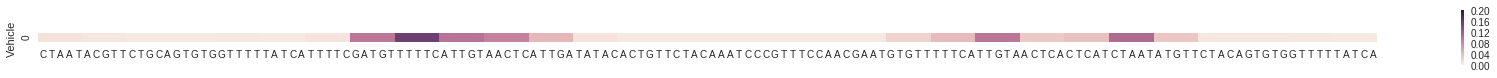

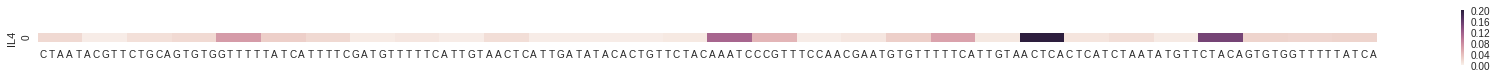

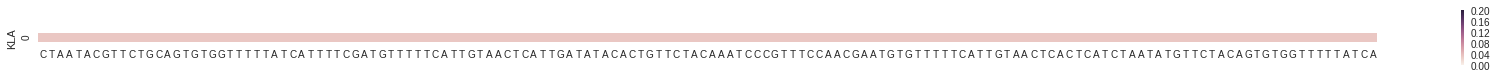

In [611]:
index = 0
attention_output, full_attention, attended_sequence = get_sequence_attention(veh_model,
                      str(positive_seqRecords[index].seq),
                      5)
frame = pd.DataFrame(full_attention).T
frame.columns = list(attended_sequence)
fig, ax = plt.subplots(figsize=(30,1)) 
hm=sns.heatmap(frame, square=True, ax=ax, vmin=0, vmax=0.20)
plt.ylabel('Vehicle')
plt.show()

attention_output, full_attention, attended_sequence = get_sequence_attention(il4_model,
                      str(positive_seqRecords[index].seq),
                      5)

frame = pd.DataFrame(full_attention).T
frame.columns = list(attended_sequence)
fig, ax = plt.subplots(figsize=(30,1)) 
hm=sns.heatmap(frame, square=True, ax=ax, vmin=0, vmax=0.20)
plt.ylabel('IL4')
plt.show()

attention_output, full_attention, attended_sequence = get_sequence_attention(kla_model,
                      str(positive_seqRecords[index].seq),
                      5)
frame = pd.DataFrame(full_attention).T
frame.columns = list(attended_sequence)
fig, ax = plt.subplots(figsize=(30,1)) 
hm=sns.heatmap(frame, square=True, ax=ax, vmin=0, vmax=0.20)
plt.ylabel('KLA')
plt.show()

## Multilabel Model

In [1047]:
def get_attention_multilabel_model(total_seq_length,
                        seq_size,
                        num_motifs, 
                        motif_size,
                        adjacent_bp_pool_size,
                        attention_dim,
                        attention_hops,
                        num_dense_neurons,
                        dropout_rate=0.25):
    input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
    input_rev = Input(shape=(total_seq_length,4), name='input_rev')

    ### find motifs ###
    convolution_layer = Conv1D(filters=num_motifs, 
        kernel_size=motif_size,
        activation='relu',
        input_shape=(total_seq_length,4),
        name='convolution_layer',
        padding = 'same'
        )
    forward_motif_scores = convolution_layer(input_fwd)
    reverse_motif_scores = convolution_layer(input_rev)
    print('forward_motif_scores', forward_motif_scores.get_shape())

    ### crop motif scores to avoid parts of sequence where motif score is computed in only one direction ###
    to_crop = int((total_seq_length - seq_size)/2)
    crop_layer = Cropping1D(cropping=(to_crop, to_crop), 
        name='crop_layer')
    cropped_fwd_scores = crop_layer(forward_motif_scores)
    cropped_rev_scores = crop_layer(reverse_motif_scores)
    print('cropped_fwd_scores', cropped_fwd_scores.get_shape())

    ### flip motif scores ###
    flip_layer = Lambda(lambda x: K.reverse(x,axes=0),
        output_shape=(seq_size, num_motifs),
        name='flip_layer')
    flipped_rev_scores = flip_layer(cropped_rev_scores)
    print('flipped_rev_scores', flipped_rev_scores.get_shape())

    ### concatenate motif scores ###
    concatenate_layer = keras.layers.Concatenate(axis=2, name='concatenate_layer')
    concatenated_motif_scores = concatenate_layer([cropped_fwd_scores, flipped_rev_scores])
    print('concatenated_motif_scores', concatenated_motif_scores.get_shape())

    ### pool across length of sequence ###
    sequence_pooling_layer = MaxPool1D(pool_size=adjacent_bp_pool_size, 
        strides=adjacent_bp_pool_size,
        name='sequence_pooling_layer')
    pooled_scores = sequence_pooling_layer(concatenated_motif_scores)
    print('pooled_scores', pooled_scores.get_shape())

    ## bidirectional LSTM ###
    forward_lstm_layer = LSTM(units=int(seq_size/adjacent_bp_pool_size),
        return_sequences=True,
        input_shape = (int(seq_size/adjacent_bp_pool_size), 2*num_motifs),
        name = 'forward_lstm_layer'
        )
    forward_hidden_states = forward_lstm_layer(pooled_scores)
    print('forward_hidden_states', forward_hidden_states.get_shape())

    reverse_lstm_layer = LSTM(units=int(seq_size/adjacent_bp_pool_size),
        return_sequences=True,
        input_shape = (int(seq_size/adjacent_bp_pool_size), 2*num_motifs),
        name = 'reverse_lstm_layer',
        go_backwards=True,
        )
    reverse_hidden_states = reverse_lstm_layer(pooled_scores)
    print('reverse_hidden_states', reverse_hidden_states.get_shape())
    ### concatenate lstm hidden states ###
    lstm_concatenate_layer = Concatenate(axis=2)
    bilstm_hidden_states = lstm_concatenate_layer([forward_hidden_states, reverse_hidden_states])

    print('bilstm_hidden_states', bilstm_hidden_states.get_shape())

    # tanh layer
    attention_tanh_layer = Dense(attention_dim,
        activation='tanh',
        use_bias=False,
        name = 'attention_tanh_layer')
    attention_tanh_layer_out = attention_tanh_layer(bilstm_hidden_states)
    print('attention_tanh_layer_out', attention_tanh_layer_out.get_shape())

    # outer layer
    attention_outer_layer = Dense(attention_hops,
        activation='linear',
        use_bias=False,
        name = 'attention_outer_layer')
    attention_outer_layer_out = attention_outer_layer(attention_tanh_layer_out)
    print('attention_outer_layer_out', attention_outer_layer_out.get_shape())

    # apply softmax
    softmax_layer = Softmax(axis=1, name='attention_softmax_layer')
    attention_softmax_layer_out = softmax_layer(attention_outer_layer_out)
    print('attention_softmax_layer_out', attention_softmax_layer_out.get_shape())

    # attend to hidden states
    attending_layer = Dot(axes=(1,1),
        name='attending_layer')

    attended_states = attending_layer([attention_softmax_layer_out, bilstm_hidden_states])
    print('attended_states', attended_states.get_shape())

    # # fully connected layer
    dense_layer = Dense(num_dense_neurons, 
        activation='relu', 
        name = 'dense_layer'
        )

    dense_output = dense_layer(attended_states)
    print('dense_output', dense_output.shape)
    
    # drop out
    drop_out = Dropout(dropout_rate,name='dense_dropout')(dense_output)
    print('drop_out', drop_out.shape)
    
    # make prediction
    flattened = Flatten(name='flatten')(drop_out)
    print('flattened', flattened.shape)
    
    predictions = Dense(num_classes,
                        name='predictions',
                        activation = 'sigmoid', 
                       )(flattened)
    print('predictions', predictions.shape)
    
    # define and compile model
    model = Model(inputs=[input_fwd, input_rev], outputs=predictions)

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['binary_accuracy'])
    return model

In [ ]:
def quantile_normalize_df(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

In [1135]:
negative_seqRecords = list(SeqIO.parse('./background.fasta', 'fasta'))
negative_seq = [str(x.seq[:200]) for x in negative_seqRecords]
negative_rc_seq = [str(x.seq[:200]) for x in negative_seqRecords]

negative_sequence_arrays = convert_sequences_to_array(negative_seq)
negative_sequence_arrays = np.array(negative_sequence_arrays)

negative_sequence_rc_arrays = convert_sequences_to_array(negative_rc_seq)
negative_sequence_rc_arrays = np.array(negative_sequence_rc_arrays)

In [1024]:
positive_seqRecords = list(SeqIO.parse('./merged_atac_peaks_filtered_resized.fasta', 'fasta'))
positive_seqRecords = [x for x in positive_seqRecords]
fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords]

fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords ]

seq_ids = [x.name for x in positive_seqRecords]

sequence_arrays = convert_sequences_to_array(fasta_seq)
sequence_arrays = np.array(sequence_arrays)

sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)
sequence_rc_arrays = np.array(sequence_rc_arrays)

index_seqArray_dict = dict(zip(seq_ids, zip(sequence_arrays, sequence_rc_arrays)))

In [1160]:
summary_frame = pd.read_csv('./group_atac_summary.tsv' , sep='\t', low_memory=False)
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
# summary_frame.index = summary_frame['ID'].values
summary_frame.index = summary_frame['chr'] + ':' + (summary_frame['start'] - 1).astype(str) + '-' + summary_frame['end'].astype(str)

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]

In [1161]:
(summary_frame[[x for x in summary_frame.columns if 'c57' in x]]>0).sum(axis=0)

c57bl6_ifng-24h    33333
c57bl6_il13-24h    23066
c57bl6_il1b-24h    13650
c57bl6_il23-24h    33482
c57bl6_il4-24h     33518
c57bl6_il5-24h      2091
c57bl6_il6-24h     20308
c57bl6_kla-1h      21776
c57bl6_tgfb-24h    29540
c57bl6_tnfa-24h    31600
c57bl6_veh-24h     11500
c57bl6_veh         31550
dtype: int64

In [1162]:
(summary_frame[[x for x in summary_frame.columns if 'c57' in x]]>0).mean(axis=0)

c57bl6_ifng-24h    0.608588
c57bl6_il13-24h    0.421135
c57bl6_il1b-24h    0.249219
c57bl6_il23-24h    0.611309
c57bl6_il4-24h     0.611966
c57bl6_il5-24h     0.038177
c57bl6_il6-24h     0.370780
c57bl6_kla-1h      0.397583
c57bl6_tgfb-24h    0.539337
c57bl6_tnfa-24h    0.576948
c57bl6_veh-24h     0.209965
c57bl6_veh         0.576035
dtype: float64

In [1163]:
peak_count_threshold = 20000
peak_counts = (summary_frame[[x for x in summary_frame.columns if 'c57' in x]]>0).sum(axis=0)
to_filter_conditions = peak_counts[peak_counts < peak_count_threshold].index.values
label_frame = summary_frame[[x for x in summary_frame.columns if 'c57' in x]]
for cond in to_filter_conditions:
    label_frame.drop(cond, axis=1, inplace=True)

/home/jenhan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1219]:
label_frame = summary_frame[['c57bl6_il4-24h', 'c57bl6_kla-1h', 'c57bl6_veh']]

In [1220]:
quantiled_label_frame = quantile_normalize_df(label_frame)

In [1221]:
label_frame.shape

(54771, 3)

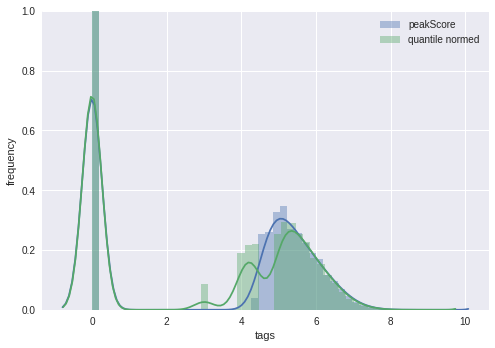

In [1222]:
sns.distplot(np.log2(np.array([x for x in label_frame.values.flatten()])+1), label = 'peakScore')
sns.distplot(np.log2(np.array([x for x in quantiled_label_frame.values.flatten()])+1), label = 'quantile normed')
plt.ylim(0,1)
plt.xlabel('tags')
plt.ylabel('frequency')
plt.legend()

In [1223]:
score_threshold = 1
labels = (quantiled_label_frame >= score_threshold + 0).values
target_indices = quantiled_label_frame[quantiled_label_frame.max(axis=1) >= score_threshold].index.values
index_label_dict = dict(zip(target_indices, labels))

In [1224]:
(quantiled_label_frame >= score_threshold + 0).sum(axis=0)

c57bl6_il4-24h    33518
c57bl6_kla-1h     21776
c57bl6_veh        31550
dtype: int64

In [1225]:
num_classes = quantiled_label_frame.shape[1]
labels = [index_label_dict[x] for x in target_indices] + [[0]*num_classes] * len(negative_seq)
labels = np.array(labels)

In [1226]:
target_seq_arrays = np.array([index_seqArray_dict[x][0] for x in target_indices])
target_seq_rc_arrays = np.array([index_seqArray_dict[x][1] for x in target_indices])

seq_arrays = np.concatenate([target_seq_arrays, negative_sequence_arrays])
seq_rc_arrays = np.concatenate([target_seq_rc_arrays, negative_sequence_rc_arrays])

In [1227]:

x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(seq_arrays, seq_rc_arrays, labels, test_size=0.2)

In [1228]:
print('label counts', labels.sum(axis=0))
print('naive accuracy', max(labels.sum(axis=0))/len(labels))

label counts [25795 16140 24768]
naive accuracy 0.2595853879440475


### Convolution Model

In [1229]:
def get_convolution_multilabel_model(total_seq_length,
                        seq_size,
                        num_motifs, 
                        motif_size):
    input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
    input_rev = Input(shape=(total_seq_length,4), name='input_rev')

    ### find motifs ###
    convolution_layer = Conv1D(filters=num_motifs, 
        kernel_size=motif_size,
        activation='relu',
        input_shape=(total_seq_length,4),
        name='convolution_layer',
        padding = 'same'
        )
    forward_motif_scores = convolution_layer(input_fwd)
    reverse_motif_scores = convolution_layer(input_rev)
    print('forward_motif_scores', forward_motif_scores.get_shape())

    ### crop motif scores to avoid parts of sequence where motif score is computed in only one direction ###
    to_crop = int((total_seq_length - seq_size)/2)
    crop_layer = Cropping1D(cropping=(to_crop, to_crop), 
        name='crop_layer')
    cropped_fwd_scores = crop_layer(forward_motif_scores)
    cropped_rev_scores = crop_layer(reverse_motif_scores)
    print('cropped_fwd_scores', cropped_fwd_scores.get_shape())

    ### flip motif scores ###
    flip_layer = Lambda(lambda x: K.reverse(x,axes=0),
        output_shape=(seq_size, num_motifs),
        name='flip_layer')
    flipped_rev_scores = flip_layer(cropped_rev_scores)
    print('flipped_rev_scores', flipped_rev_scores.get_shape())

    ### pool across length of sequence ###
    sequence_pooling_layer = MaxPool1D(pool_size=seq_size, 
        strides=adjacent_bp_pool_size,
        name='sequence_pooling_layer')
    pooled_fwd_scores = sequence_pooling_layer(cropped_fwd_scores)
    pooled_rev_scores = sequence_pooling_layer(cropped_rev_scores)
    print('pooled_fwd_scores', pooled_fwd_scores.get_shape())
    print('pooled_rev_scores', pooled_rev_scores.get_shape())

    ### concatenate motif scores ###
    concatenate_layer = keras.layers.Concatenate(axis=1, name='concatenate_layer')
    concatenated_motif_scores = concatenate_layer([pooled_fwd_scores, pooled_rev_scores])
    print('concatenated_motif_scores', concatenated_motif_scores.get_shape())

    ## pool across forward and reverse strand ###
    strand_pooling_layer = MaxPool1D(pool_size=2, 
        strides=2,
        name='strand_pooling_layer',
        )
    pooled_strand_scores = strand_pooling_layer(concatenated_motif_scores)
    print('pooled_strand_scores', pooled_strand_scores.shape)
    
    # make prediction
    flattened = Flatten(name='flatten')(pooled_strand_scores)
    print('flattened', flattened.shape)
    
    predictions = Dense(num_classes,
                        name='predictions',
                        activation = 'relu', 
                       )(flattened)
    print('predictions', predictions.shape)
    
    # define and compile model
    model = Model(inputs=[input_fwd, input_rev], outputs=predictions)

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=keras.optimizers.adam(),
                  metrics=['binary_accuracy'])
    return model

In [1178]:
num_classes = len(labels[0])
total_seq_length = 200
seq_size = 150
num_motifs = 30
motif_size = 20
adjacent_bp_pool_size = 5
attention_dim = 100
attention_hops = 1
num_dense_neurons = 100 

In [1179]:
signal_convolution_model = get_convolution_multilabel_model(total_seq_length,
                        seq_size,
                        num_motifs, 
                        motif_size
                                                           )

forward_motif_scores (?, 200, 30)
cropped_fwd_scores (?, 150, 30)
flipped_rev_scores (?, 150, 30)
pooled_fwd_scores (?, 1, 30)
pooled_rev_scores (?, 1, 30)
concatenated_motif_scores (?, 2, 30)
pooled_strand_scores (?, 1, 30)
flattened (?, ?)
predictions (?, 9)


In [ ]:
signal_convolution_model.fit([x_train, x_rc_train], y_train,
          batch_size=128,
          epochs=50,
          verbose=1,
          validation_data=([x_test, x_rc_test], y_test))
score = signal_convolution_model.evaluate([x_test, x_rc_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
signal_convolution_model.predict([x_train[0:100], x_rc_train[0:100]])

### Attention Model

In [1239]:
num_classes = len(labels[0])
total_seq_length = 200
seq_size = 150
num_motifs = 25
motif_size = 20
adjacent_bp_pool_size = 5
attention_dim = 100
attention_hops = 1
num_dense_neurons = 100 

signal_model = get_attention_multilabel_model(total_seq_length,
                        seq_size,
                        num_motifs, 
                        motif_size,
                        adjacent_bp_pool_size,
                        attention_dim,
                        attention_hops,
                        num_dense_neurons,
                        dropout_rate=0.25)

forward_motif_scores (?, 200, 25)
cropped_fwd_scores (?, 150, 25)
flipped_rev_scores (?, 150, 25)
concatenated_motif_scores (?, 150, 50)
pooled_scores (?, 30, 50)
forward_hidden_states (?, ?, 30)
reverse_hidden_states (?, ?, 30)
bilstm_hidden_states (?, ?, 60)
attention_tanh_layer_out (?, 30, 100)
attention_outer_layer_out (?, 30, 1)
attention_softmax_layer_out (?, 30, 1)
attended_states (?, 1, 60)
dense_output (?, 1, 100)
drop_out (?, 1, 100)
flattened (?, ?)
predictions (?, 3)


In [1240]:
signal_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_fwd (InputLayer)          (None, 200, 4)       0                                            
__________________________________________________________________________________________________
input_rev (InputLayer)          (None, 200, 4)       0                                            
__________________________________________________________________________________________________
convolution_layer (Conv1D)      (None, 200, 25)      2025        input_fwd[0][0]                  
                                                                 input_rev[0][0]                  
__________________________________________________________________________________________________
crop_layer (Cropping1D)         (None, 150, 25)      0           convolution_layer[0][0]          
          

In [1241]:
parallel_attention_model = keras.utils.multi_gpu_model(signal_model, gpus=2)
parallel_attention_model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

In [1242]:
parallel_attention_model.fit([x_train, x_rc_train], y_train,
          batch_size=200,
          epochs=50,
          verbose=1,
          validation_data=([x_test, x_rc_test], y_test))
score = signal_model.evaluate([x_test, x_rc_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 79496 samples, validate on 19874 samples
Epoch 1/50
79496/79496 [==============================] - 51s 644us/step - loss: 0.5290 - acc: 0.7745 - val_loss: 0.5165 - val_acc: 0.7764
Epoch 2/50
79496/79496 [==============================] - 29s 368us/step - loss: 0.4900 - acc: 0.7762 - val_loss: 0.4739 - val_acc: 0.7770
Epoch 3/50
79496/79496 [==============================] - 29s 371us/step - loss: 0.4680 - acc: 0.7783 - val_loss: 0.4598 - val_acc: 0.7787
Epoch 4/50
79496/79496 [==============================] - 29s 368us/step - loss: 0.4583 - acc: 0.7804 - val_loss: 0.4620 - val_acc: 0.7790
Epoch 5/50
79496/79496 [==============================] - 29s 369us/step - loss: 0.4496 - acc: 0.7826 - val_loss: 0.4482 - val_acc: 0.7837
Epoch 6/50
79496/79496 [==============================] - 29s 369us/step - loss: 0.4425 - acc: 0.7840 - val_loss: 0.4488 - val_acc: 0.7807
Epoch 7/50
79496/79496 [==============================] - 29s 368us/step - loss: 0.4368 - acc: 0.7864 - val_loss: 0.

In [1243]:
predictions = signal_model.predict([x_test, x_rc_test])

In [ ]:
np.round(predictions[:2])

In [ ]:
print(sklearn.metrics.classification_report(np.round(predictions), y_test))

In [1218]:
print(sklearn.metrics.accuracy_score(np.round(predictions), y_test))

0.4882170259408111


In [ ]:
# # serialize model to JSON
# model_json = signal_model.to_json()
# with open("signal_model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# signal_model.save_weights("signal_model.h5")
# print("Saved model to disk")
 